__This notebook codes Decision Tree algo from scratch__

Sunday, April 17, 2022

Version 1 will also include a ppt
Version 2 will include type hints 
Version 3 will convert this into a py script
Version 4 and beyond will build out other functions such as: 
 - Optimization 
 - Cross Entropy loss 
 - Tree Pruning 
 - Regression
 - Equality instead of ranking for categorical inputs (see source) 
 
Much of this version can be credited to: https://machinelearningmastery.com/implement-decision-tree-algorithm-scratch-python/

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

__Sample Data__

In [2]:
# Load the data
data = pd.read_csv("data_banknote_authentication.txt")
# Give column headers 
data.columns = ['variance', 'skewness', 'kurtosis', 'entropy', 'class']
# View the dataframe
data.head()

,variance,skewness,kurtosis,entropy,class
0,4.54590,8.1674,-2.4586,-1.46210,0
1,3.86600,-2.6383,1.9242,0.10645,0
2,3.45660,9.5228,-4.0112,-3.59440,0
3,0.32924,-4.4552,4.5718,-0.98880,0
4,4.36840,9.6718,-3.9606,-3.16250,0


In [3]:
# Inspect the data
data.info() # All numeric data; 4 continuous, 1 integer 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1371 entries, 0 to 1370
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   variance  1371 non-null   float64
 1   skewness  1371 non-null   float64
 2   kurtosis  1371 non-null   float64
 3   entropy   1371 non-null   float64
 4   class     1371 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 53.7 KB


In [4]:
# See summary statistics 
data.describe()

,variance,skewness,kurtosis,entropy,class
count,1371.000000,1371.000000,1371.000000,1371.000000,1371.000000
mean,0.431410,1.917434,1.400694,-1.192200,0.444931
std,2.842494,5.868359,4.310105,2.101683,0.497139
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.774700,-1.711300,-1.553350,-2.417000,0.000000
50%,0.495710,2.313400,0.616630,-0.586650,0.000000
75%,2.814650,6.813100,3.181600,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


variance


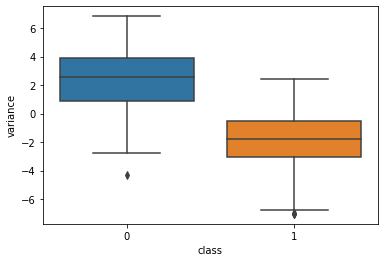

skewness


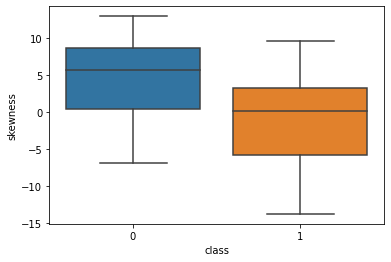

kurtosis


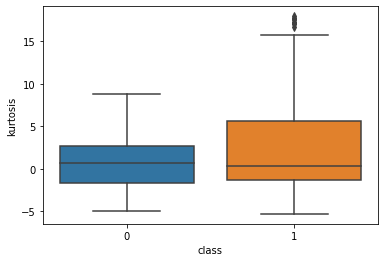

entropy


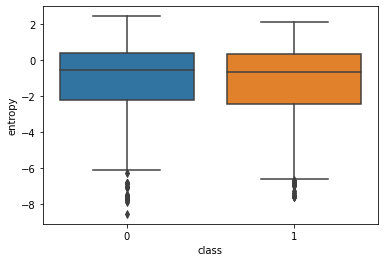

In [5]:
# Are the predictors potentially good predictors of class
for feature in data.columns[:4]:
    print (feature)
    sns.boxplot(x = 'class', y = feature, data = data)
    plt.show()

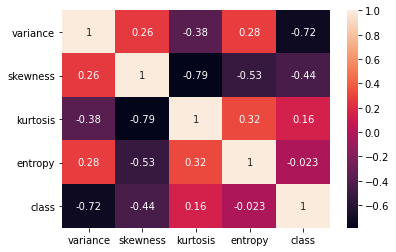

In [6]:
# Check the correlation between variables
corr = data.corr(method='pearson', min_periods=1)
sns.heatmap(corr, annot=True)
plt.show() # There is high correlation between kurtosis and skewness. Perhaps one of them is not necessary 

__Gini Index__

Image of math 

To evaluate splits

In [7]:
# calculate the Gini index for a split dataset
def gini_index(groups, classes):
    # count all samples at split point: 
    #print([len(group) for group in groups])
    n_instances = float(sum([len(group) for group in groups]))
    #print(n_instances)
    #sum weighted Gini index for each group 
    gini = 0.0 
    for group in groups: 
        size = float (len(group))
        # avoid divide by zero 
        if size == 0: 
            continue 
        score = 0.0 
        #score the group based on the score for each class 
        for class_val in classes: 
            #print(class_val)
            p = [row[-1] for row in group].count(class_val) / size 
            #print([row[-1] for row in group])
            #print ('p:', p)
            score += p * p 
        # weight the group score by its relative size 
        gini += (1.0 - score) * (size / n_instances)
    return gini 

In [8]:
groups = [[[1, 1], [1, 0]], [[1, 0], [1, 1]], [[1, 1], [1, 0]]]
pd.DataFrame(groups)

,0,1
0,"[1, 1]","[1, 0]"
1,"[1, 0]","[1, 1]"
2,"[1, 1]","[1, 0]"


In [9]:
gini_index(groups, [0, 1])

0.5

In [10]:
groups = [[[1, 1], [1, 0]], [[1, 0], [1, 1]]]
pd.DataFrame(groups)

,0,1
0,"[1, 1]","[1, 0]"
1,"[1, 0]","[1, 1]"


In [11]:
gini_index(groups, [0, 1])

0.5

__Create Split__

In [12]:
# Split a dataset based on an attribute and an attribute value 
def test_split(index, value, dataset):
    left, right = list(), list()
    for row in dataset: 
        if row[index] <value: 
            left.append(row)
        else: 
            right.append(row)
    return left, right 

In [13]:
def get_split(dataset):
    class_values = list (set(row[-1] for row in dataset))
    b_index, b_value, b_score, b_groups = 999, 999, 999, None 
    for index in range (len(dataset[0])-1):
        for row in dataset:
            groups = test_split(index, row[index], dataset)
            gini= gini_index(groups, class_values)
            print('X%d < %.3f Gini=%.3f' % ((index+1), row[index], gini))
            if gini < b_score: 
                b_index, b_value, b_score, b_groups = index, row[index], gini, groups
    return {'index': b_index, 'value': b_value, 'groups':b_groups}

In [14]:
dataset = [[2.771244718,1.784783929,0],
[1.728571309,1.169761413,0],
[3.678319846,2.81281357,0],
[3.961043357,2.61995032,0],
[2.999208922,2.209014212,0],
[7.497545867,3.162953546,1],
[9.00220326,3.339047188,1],
[7.444542326,0.476683375,1],
[10.12493903,3.234550982,1],
[6.642287351,3.319983761,1]]
dataset

[[2.771244718, 1.784783929, 0],
 [1.728571309, 1.169761413, 0],
 [3.678319846, 2.81281357, 0],
 [3.961043357, 2.61995032, 0],
 [2.999208922, 2.209014212, 0],
 [7.497545867, 3.162953546, 1],
 [9.00220326, 3.339047188, 1],
 [7.444542326, 0.476683375, 1],
 [10.12493903, 3.234550982, 1],
 [6.642287351, 3.319983761, 1]]

In [15]:
split = get_split(dataset)

X1 < 2.771 Gini=0.444
X1 < 1.729 Gini=0.500
X1 < 3.678 Gini=0.286
X1 < 3.961 Gini=0.167
X1 < 2.999 Gini=0.375
X1 < 7.498 Gini=0.286
X1 < 9.002 Gini=0.375
X1 < 7.445 Gini=0.167
X1 < 10.125 Gini=0.444
X1 < 6.642 Gini=0.000
X2 < 1.785 Gini=0.500
X2 < 1.170 Gini=0.444
X2 < 2.813 Gini=0.320
X2 < 2.620 Gini=0.417
X2 < 2.209 Gini=0.476
X2 < 3.163 Gini=0.167
X2 < 3.339 Gini=0.444
X2 < 0.477 Gini=0.500
X2 < 3.235 Gini=0.286
X2 < 3.320 Gini=0.375


In [16]:
print('Split: [X%d < %.3f]' % ((split['index']+1), split['value']))

Split: [X1 < 6.642]


__Build a Tree__

In [17]:
# Create a terminal node value 
def to_terminal(group):
    outcomes = [row[-1] for row in group]
    return max(set(outcomes), key = outcomes.count) # Remember this line of code for interviews

In [18]:
# Create child splits for a node or make terminal 
def split(node, max_depth, min_size, depth):
    left, right = node['groups']
    del(node['groups'])
    # check for a no split 
    if not left or not right: 
        node['left'] = node ['right'] = to_terminal(left + right)
        return 
    # check for max depth
    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return
    # process left child 
    if len(left) <= min_size:
        node['left'] = to_terminal(left)
    else: 
        node['left'] = get_split(left)
        split(node['left'], max_depth, min_size, depth+1)
    # process right child 
    if len(right) <= min_size:
        node['right'] = to_terminal(right)
    else: 
        node['right'] = get_split(right)
        split(node['right'], max_depth, min_size, depth+1)        

In [19]:
# Build a decision tree 
def build_tree(train, max_depth, min_size):
    root = get_split(train)
    split(root, max_depth, min_size, 1)
    return root

In [20]:
def print_tree(node, depth=0):
    if isinstance(node, dict): 
        print('%s[X%d < %.3f]' % ((depth*' ', (node['index']+1), node['value'])))
        print_tree(node['left'], depth+1)
        print_tree(node['right'], depth+1)
    else: 
        print('%s[%s]' % ((depth*' ', node)))

In [21]:
tree = build_tree(dataset, 1, 1)

X1 < 2.771 Gini=0.444
X1 < 1.729 Gini=0.500
X1 < 3.678 Gini=0.286
X1 < 3.961 Gini=0.167
X1 < 2.999 Gini=0.375
X1 < 7.498 Gini=0.286
X1 < 9.002 Gini=0.375
X1 < 7.445 Gini=0.167
X1 < 10.125 Gini=0.444
X1 < 6.642 Gini=0.000
X2 < 1.785 Gini=0.500
X2 < 1.170 Gini=0.444
X2 < 2.813 Gini=0.320
X2 < 2.620 Gini=0.417
X2 < 2.209 Gini=0.476
X2 < 3.163 Gini=0.167
X2 < 3.339 Gini=0.444
X2 < 0.477 Gini=0.500
X2 < 3.235 Gini=0.286
X2 < 3.320 Gini=0.375


In [22]:
print_tree(tree)

[X1 < 6.642]
 [0]
 [1]


In [23]:
tree = build_tree(dataset, 2, 1)
print_tree(tree)

X1 < 2.771 Gini=0.444
X1 < 1.729 Gini=0.500
X1 < 3.678 Gini=0.286
X1 < 3.961 Gini=0.167
X1 < 2.999 Gini=0.375
X1 < 7.498 Gini=0.286
X1 < 9.002 Gini=0.375
X1 < 7.445 Gini=0.167
X1 < 10.125 Gini=0.444
X1 < 6.642 Gini=0.000
X2 < 1.785 Gini=0.500
X2 < 1.170 Gini=0.444
X2 < 2.813 Gini=0.320
X2 < 2.620 Gini=0.417
X2 < 2.209 Gini=0.476
X2 < 3.163 Gini=0.167
X2 < 3.339 Gini=0.444
X2 < 0.477 Gini=0.500
X2 < 3.235 Gini=0.286
X2 < 3.320 Gini=0.375
X1 < 2.771 Gini=0.000
X1 < 1.729 Gini=0.000
X1 < 3.678 Gini=0.000
X1 < 3.961 Gini=0.000
X1 < 2.999 Gini=0.000
X2 < 1.785 Gini=0.000
X2 < 1.170 Gini=0.000
X2 < 2.813 Gini=0.000
X2 < 2.620 Gini=0.000
X2 < 2.209 Gini=0.000
X1 < 7.498 Gini=0.000
X1 < 9.002 Gini=0.000
X1 < 7.445 Gini=0.000
X1 < 10.125 Gini=0.000
X1 < 6.642 Gini=0.000
X2 < 3.163 Gini=0.000
X2 < 3.339 Gini=0.000
X2 < 0.477 Gini=0.000
X2 < 3.235 Gini=0.000
X2 < 3.320 Gini=0.000
[X1 < 6.642]
 [X1 < 2.771]
  [0]
  [0]
 [X1 < 7.498]
  [1]
  [1]


In [24]:
tree = build_tree(dataset, 3, 1)
print_tree(tree)

X1 < 2.771 Gini=0.444
X1 < 1.729 Gini=0.500
X1 < 3.678 Gini=0.286
X1 < 3.961 Gini=0.167
X1 < 2.999 Gini=0.375
X1 < 7.498 Gini=0.286
X1 < 9.002 Gini=0.375
X1 < 7.445 Gini=0.167
X1 < 10.125 Gini=0.444
X1 < 6.642 Gini=0.000
X2 < 1.785 Gini=0.500
X2 < 1.170 Gini=0.444
X2 < 2.813 Gini=0.320
X2 < 2.620 Gini=0.417
X2 < 2.209 Gini=0.476
X2 < 3.163 Gini=0.167
X2 < 3.339 Gini=0.444
X2 < 0.477 Gini=0.500
X2 < 3.235 Gini=0.286
X2 < 3.320 Gini=0.375
X1 < 2.771 Gini=0.000
X1 < 1.729 Gini=0.000
X1 < 3.678 Gini=0.000
X1 < 3.961 Gini=0.000
X1 < 2.999 Gini=0.000
X2 < 1.785 Gini=0.000
X2 < 1.170 Gini=0.000
X2 < 2.813 Gini=0.000
X2 < 2.620 Gini=0.000
X2 < 2.209 Gini=0.000
X1 < 2.771 Gini=0.000
X1 < 3.678 Gini=0.000
X1 < 3.961 Gini=0.000
X1 < 2.999 Gini=0.000
X2 < 1.785 Gini=0.000
X2 < 2.813 Gini=0.000
X2 < 2.620 Gini=0.000
X2 < 2.209 Gini=0.000
X1 < 7.498 Gini=0.000
X1 < 9.002 Gini=0.000
X1 < 7.445 Gini=0.000
X1 < 10.125 Gini=0.000
X1 < 6.642 Gini=0.000
X2 < 3.163 Gini=0.000
X2 < 3.339 Gini=0.000
X2 < 0.4

__Make a Prediction__

In [25]:
def predict(node, row):
    if row[node['index']] <node['value']:
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        else: 
            return node['left']
    else: 
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else: 
            return node['right']

__Banknote Case Study__

In [26]:
from random import randrange

In [27]:
# Split a dataset into k folds
def cross_validation_split(dataset, n_folds):
    dataset_split = list()
    dataset_copy = list(dataset)
    fold_size = int(len(dataset)/n_folds)
    for i in range(n_folds):
        fold = list()
        while len(fold) < fold_size:
            index = randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    return dataset_split

In [28]:
# Calculate accuracy percentage 
def accuracy_metric(actual, predicted):
    correct = 0 
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct +=1
    return correct / float(len(actual)) * 100.0

In [36]:
# Evaluate an algorithm using a cross validation split
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
    folds = cross_validation_split(dataset, n_folds)
    scores = list()
    for fold in folds: 
        train_set = list(folds)
        train_set.remove(fold)
        train_set = sum(train_set, [])
        test_set = list()
        for row in fold:
            row_copy = list(row)
            test_set.append(row_copy)
            row_copy[-1] = None 
            predicted = algorithm(train_set, test_set, *args)
            actual = [row[-1] for row in fold]
            accuracy = accuracy_metric(actual, predicted)
            scores.append(accuracy)
        return scores

In [37]:
# Classification and Regression Tree Algorithm
def decision_tree(train, test, max_depth, min_size):
    tree = build_tree(train, max_depth, min_size)
    predictions = list()
    for row in test:
        prediction = predict(tree, row)
        predictions.append(prediction)
    return(predictions)

In [38]:
# Test CART on Bank Note dataset
# evaluate algorithm
n_folds = 5
max_depth = 5
min_size = 10
scores = evaluate_algorithm(dataset, decision_tree, n_folds, max_depth, min_size)
print('Scores: %s' % scores)
print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))

X1 < 9.002 Gini=0.333
X1 < 10.125 Gini=0.429
X1 < 1.729 Gini=0.500
X1 < 7.498 Gini=0.200
X1 < 3.678 Gini=0.333
X1 < 3.961 Gini=0.200
X1 < 2.771 Gini=0.429
X1 < 6.642 Gini=0.000
X2 < 3.339 Gini=0.429
X2 < 3.235 Gini=0.200
X2 < 1.170 Gini=0.500
X2 < 3.163 Gini=0.000
X2 < 2.813 Gini=0.200
X2 < 2.620 Gini=0.333
X2 < 1.785 Gini=0.429
X2 < 3.320 Gini=0.333


IndexError: list index out of range

In [40]:
# CART on the Bank Note dataset
from random import seed
from random import randrange
from csv import reader
 
# Load a CSV file
def load_csv(filename):
	file = open(filename, "rt")
	lines = reader(file)
	dataset = list(lines)
	return dataset
 
# Convert string column to float
def str_column_to_float(dataset, column):
	for row in dataset:
		row[column] = float(row[column].strip())
 
# Split a dataset into k folds
def cross_validation_split(dataset, n_folds):
	dataset_split = list()
	dataset_copy = list(dataset)
	fold_size = int(len(dataset) / n_folds)
	for i in range(n_folds):
		fold = list()
		while len(fold) < fold_size:
			index = randrange(len(dataset_copy))
			fold.append(dataset_copy.pop(index))
		dataset_split.append(fold)
	return dataset_split
 
# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
	correct = 0
	for i in range(len(actual)):
		if actual[i] == predicted[i]:
			correct += 1
	return correct / float(len(actual)) * 100.0
 
# Evaluate an algorithm using a cross validation split
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
	folds = cross_validation_split(dataset, n_folds)
	scores = list()
	for fold in folds:
		train_set = list(folds)
		train_set.remove(fold)
		train_set = sum(train_set, [])
		test_set = list()
		for row in fold:
			row_copy = list(row)
			test_set.append(row_copy)
			row_copy[-1] = None
		predicted = algorithm(train_set, test_set, *args)
		actual = [row[-1] for row in fold]
		accuracy = accuracy_metric(actual, predicted)
		scores.append(accuracy)
	return scores
 
# Split a dataset based on an attribute and an attribute value
def test_split(index, value, dataset):
	left, right = list(), list()
	for row in dataset:
		if row[index] < value:
			left.append(row)
		else:
			right.append(row)
	return left, right
 
# Calculate the Gini index for a split dataset
def gini_index(groups, classes):
	# count all samples at split point
	n_instances = float(sum([len(group) for group in groups]))
	# sum weighted Gini index for each group
	gini = 0.0
	for group in groups:
		size = float(len(group))
		# avoid divide by zero
		if size == 0:
			continue
		score = 0.0
		# score the group based on the score for each class
		for class_val in classes:
			p = [row[-1] for row in group].count(class_val) / size
			score += p * p
		# weight the group score by its relative size
		gini += (1.0 - score) * (size / n_instances)
	return gini
 
# Select the best split point for a dataset
def get_split(dataset):
	class_values = list(set(row[-1] for row in dataset))
	b_index, b_value, b_score, b_groups = 999, 999, 999, None
	for index in range(len(dataset[0])-1):
		for row in dataset:
			groups = test_split(index, row[index], dataset)
			gini = gini_index(groups, class_values)
			if gini < b_score:
				b_index, b_value, b_score, b_groups = index, row[index], gini, groups
	return {'index':b_index, 'value':b_value, 'groups':b_groups}
 
# Create a terminal node value
def to_terminal(group):
	outcomes = [row[-1] for row in group]
	return max(set(outcomes), key=outcomes.count)
 
# Create child splits for a node or make terminal
def split(node, max_depth, min_size, depth):
	left, right = node['groups']
	del(node['groups'])
	# check for a no split
	if not left or not right:
		node['left'] = node['right'] = to_terminal(left + right)
		return
	# check for max depth
	if depth >= max_depth:
		node['left'], node['right'] = to_terminal(left), to_terminal(right)
		return
	# process left child
	if len(left) <= min_size:
		node['left'] = to_terminal(left)
	else:
		node['left'] = get_split(left)
		split(node['left'], max_depth, min_size, depth+1)
	# process right child
	if len(right) <= min_size:
		node['right'] = to_terminal(right)
	else:
		node['right'] = get_split(right)
		split(node['right'], max_depth, min_size, depth+1)
 
# Build a decision tree
def build_tree(train, max_depth, min_size):
	root = get_split(train)
	split(root, max_depth, min_size, 1)
	return root
 
# Make a prediction with a decision tree
def predict(node, row):
	if row[node['index']] < node['value']:
		if isinstance(node['left'], dict):
			return predict(node['left'], row)
		else:
			return node['left']
	else:
		if isinstance(node['right'], dict):
			return predict(node['right'], row)
		else:
			return node['right']
 
# Classification and Regression Tree Algorithm
def decision_tree(train, test, max_depth, min_size):
	tree = build_tree(train, max_depth, min_size)
	predictions = list()
	for row in test:
		prediction = predict(tree, row)
		predictions.append(prediction)
	return(predictions)
 
# Test CART on Bank Note dataset
seed(1)
# load and prepare data
filename = 'data_banknote_authentication.txt'
dataset = load_csv(filename)
# convert string attributes to integers
for i in range(len(dataset[0])):
	str_column_to_float(dataset, i)
# evaluate algorithm
n_folds = 5
max_depth = 5
min_size = 10
scores = evaluate_algorithm(dataset, decision_tree, n_folds, max_depth, min_size)
print('Scores: %s' % scores)
print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))

Scores: [96.35036496350365, 97.08029197080292, 97.44525547445255, 98.17518248175182, 97.44525547445255]
Mean Accuracy: 97.299%
